<a href="https://colab.research.google.com/github/0902338471/GMM-CinnamonAI/blob/master/GMM_CinnamonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Import necessary libraries and tools**

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.io 

In [0]:
root_path = "/content/drive/My Drive/CinnamonAI/Gaussian-Model/"

In [0]:
#loading data and split X,y features.
data = scipy.io.loadmat(root_path+"cardio.mat")
X = data["X"]
y= data["y"]

In [0]:
pd.Series(y[:,0])[1650:1700]

**Previous cell show that abnormal instances end at 1655 index**

In [0]:
#splitting train test base on previous anomaly ratio of train test samples
X_train = X[:1655]
X_test = X[1655:]

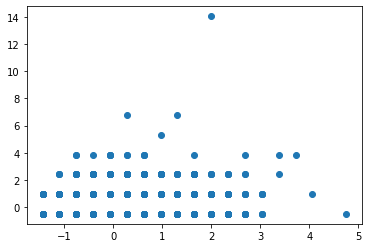

In [0]:
X_first_two_features = X_train[:,14:16]
df = pd.DataFrame(X_first_two_features)
plt.scatter(df[0],df[1])

**GMM-sklearn**

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
gmm = GaussianMixture(n_components=3)
gmm.fit(df)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
labels = gmm.predict(df) 
df['labels']= labels
d0 = df[df['labels']== 0] 
d1 = df[df['labels']== 1]
d2 = df[df['labels']== 2] 

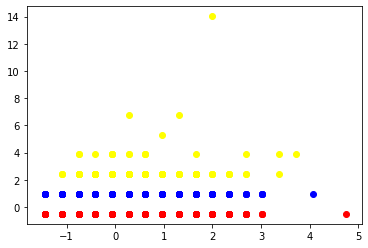

In [0]:
plt.scatter(d0[0], d0[1], c ='r') 
plt.scatter(d1[0], d1[1], c ='yellow') 
plt.scatter(d2[0], d2[1], c ='b') 
